In [30]:
#
# JRA-55 FAX天気図　FXFE5782 / FXFE5784の　700hPa湿数、500hPa気温予想図
#   2021/12/02 R.Kurora
#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage.filters import maximum_filter, minimum_filter
import sys
#
import math
import datetime
from dateutil import tz

In [31]:
## 緯度経度で指定したポイントの図上の座標などを取得する関数 transform_lonlat_to_figure() 
# 図法の座標 => pixel座標 => 図の座標　と3回の変換を行う
#  　pixel座標: plt.figureで指定した大きさxDPIに合わせ、左下を原点とするpixelで測った座標   
#  　図の座標: axesで指定した範囲を(0,1)x(0,1)とする座標
# 3つの座標を出力する
#    図の座標, Pixel座標, 図法の座標
def transform_lonlat_to_figure(lonlat, ax, proj):
    # lonlat:経度と緯度  (lon, lat) 
    # ax: Axes図の座標系    ex. fig.add_subplot()の戻り値
    # proj: axで指定した図法 
    #
    # 例 緯度経度をpointで与え、ステレオ図法る場合
    #    point = (140.0,35.0)
    #    proj= ccrs.Stereographic(central_latitude=60, central_longitude=140) 
    #    fig = plt.figure(figsize=(20,16))
    #    ax = fig.add_subplot(1, 1, 1, projection=proj)
    #    ax.set_extent([108, 156, 17, 55], ccrs.PlateCarree())
    #
    ## 図法の変換
    # 参照  https://scitools.org.uk/cartopy/docs/v0.14/crs/index.html                    
    point_proj = proj.transform_point(*lonlat, ccrs.PlateCarree())
    #
    # pixel座標へ変換
    # 参照　https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html
    point_pix = ax.transData.transform(point_proj)
    #
    # 図の座標へ変換                                                           
    point_fig = ax.transAxes.inverted().transform(point_pix)
    return point_fig, point_pix, point_proj

In [32]:
## 極大/極小ピーク検出関数                                                             
def detect_peaks(image, filter_size=3, dist_cut=5.0, flag=0):
    # filter_size: この値xこの値 の範囲内の最大値のピークを検出                        
    # dist_cut: この距離内のピークは1つにまとめる                                      
    # flag:  0:maximum検出  0以外:minimum検出                                          
    if flag==0:
      local_max = maximum_filter(image,
            footprint=np.ones((filter_size, filter_size)), mode='constant')
      detected_peaks = np.ma.array(image, mask=~(image == local_max))
    else:
      local_min = minimum_filter(image,
            footprint=np.ones((filter_size, filter_size)), mode='constant')
      detected_peaks = np.ma.array(image, mask=~(image == local_min))
    peaks_index = np.where((detected_peaks.mask != True))
    # peak間の距離行例を求める                                                         
    (x,y) = peaks_index
    size=y.size
    dist=np.full((y.size, y.size), -1.0)
    for i in range(size):
      for j in range(size):
        if i == j:
          dist[i][j]=0.0
        elif i>j:
          d = math.sqrt(((y[i] - y[j])*(y[i] - y[j]))
                        +((x[i] - x[j])*(x[i] - x[j])))
          dist[i][j]= d
          dist[j][i]= d
    # 距離がdist_cut内のpeaksの距離の和と、そのピーク番号を取得する 
    Kinrin=[]
    dSum=[]
    for i in range(size):
      tmpA=[]
      distSum=0.0
      for j in range(size):
        if dist[i][j] < dist_cut and dist[i][j] > 0.0:
          tmpA.append(j)
          distSum=distSum+dist[i][j]
      dSum.append(distSum)
      Kinrin.append(tmpA)
    # Peakから外すPeak番号を求める.  peak間の距離和が最も小さいものを残す              
    cutPoint=[]
    for i in range(size):
      val = dSum[i]
      val_i=image[x[i]][y[i]]
      for k in Kinrin[i]:
        val_k=image[x[k]][y[k]]
        if flag==0 and val_i < val_k:
            cutPoint.append(i)
            break
        if flag!=0 and val_i > val_k:
            cutPoint.append(i)
            break
        if val > dSum[k]:
            cutPoint.append(i)
            break
        if val == dSum[k] and i > k:
            cutPoint.append(i)
            break
    # 戻り値用に外すpeak番号を配列から削除                                             
    newx=[]
    newy=[]
    for i in range(size):
      if (i in cutPoint):
        continue
      newx.append(x[i])
      newy.append(y[i])
    peaks_index=(np.array(newx),np.array(newy))
    return peaks_index

In [33]:
## 読み込みデータの指定
# JRA55の読み込む年月日時をUTCで与えます。
i_year =1964
i_month = 7
i_day = 17
i_hourZ = 18
# 表示気圧面
preT=500      # 等温度線
preTTd=700    # 露点差のシェード表示
preAry=[preT, preTTd]
# データ切り出し領域
lat_cut=slice(80.0,-20.0)
lon_cut=slice(70.0,190.0)
#
# データ格納先フォルダー名
# !!!　　UGRD_yyyymm.nc  などの保存先
DataFd="./data/Jra55/"
#
## 描画指定
# 地図の描画範囲指定
#i_area = [115, 151, 20, 50]  # 日本付近
i_area = [108, 156, 17, 55]   # FEAX
#i_area = [105, 180,  0, 65]   # ASAS
# 緯線・経線の指定
dlon,dlat=10,10   # 10度ごとに
## 気温　等値線
levels_tmp =np.arange(-60,30,3)
## 露点差 ハッチ 
levels_h_ttd=[0, 3, 6, 18, 100]
levels_h_ttd_col=['green','0.9','1.0','yellow']
## 露点差 等値線
levels_ttd=np.arange(3,30,3)

In [34]:
## データ読み込み、データセット作成
# time番号                                                                 
time_targ=(i_day - 1) * 4 + i_hourZ // 6
# JRA55 Hight(HGT) RelativeVR(RELV)                                        
yyyymm='{:04d}{:02d}'.format(i_year,i_month)
#
## 月別のNetCDF File名
# 気温
TmpFn = '{}TMP_{}.nc'.format(DataFd,yyyymm)
# 湿数
DeprFn = '{}DEPR_{}.nc'.format(DataFd,yyyymm)
#
## 気温                                                                    
ds = xr.open_dataset(TmpFn)
dataTmp= ds.metpy.parse_cf('TMP').squeeze()
dataTmp.attrs['units'] = 'K'                                              
dataTmp = dataTmp.isel(time=time_targ)
dataTmp= dataTmp.sel(level=preAry,lat=lat_cut,lon=lon_cut)
#
## 湿数                                                                   
ds = xr.open_dataset(DeprFn)
dataDepr= ds.metpy.parse_cf('DEPR').squeeze()
dataDepr.attrs['units'] = 'K'
dataDepr = dataDepr.isel(time=time_targ)
dataDepr= dataDepr.sel(level=preAry,lat=lat_cut,lon=lon_cut)
#
## for check
levels = np.array([g['level'] for g in dataDepr])
print(levels)

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


[500. 700.]


In [35]:
## Datasetに変換する   
ds = xr.Dataset(
    {
        "temperature": (["level","lat", "lon"], np.array(dataTmp) * units('K')),
        "ttd": (["level","lat", "lon"], np.array(dataDepr) * units('K')),
    },
    coords={
        "level": np.array(dataTmp["level"]) * units.hPa,
        "lon": np.array(dataTmp["lon"]) * units('degrees_east'),
        "lat": np.array(dataTmp["lat"]) * units('degrees_north'),
        "time": np.array(dataTmp["time"])
    }
)
ds['temperature'].attrs['units']='K'
ds['ttd'].attrs['units']='K'
ds['level'].attrs['units'] = 'hPa'
ds['lat'].attrs['units'] = 'degrees_north'
ds['lon'].attrs['units'] = 'degrees_east'
#
dsp= ds.metpy.parse_cf()
#
## test output
#print(dsp)
#print(dsp['temperature'][0].values.max())
#print(dsp['temperature'][1].values.max())
#print(dsp['ttd'][0].values.max())
#print(dsp['ttd'][1].values.max())
#print(dsp['level'])

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [36]:
## 時刻文字列化                                                            
UTC = tz.gettz("UTC")
dt1 = datetime.datetime.fromtimestamp(dataTmp.time.astype(datetime.datetime) * 1e-9, tz=UTC)
dt_str = (dt1.strftime("%HZ%d%b%Y")).upper()
dt_str2 = dt1.strftime("%Y%m%d%H")
print(dt_str)
print(dt_str2)

18Z17JUL1964
1964071718


/var/folders/sg/7nc0dtk94334h_fcm2j1glym0000gn/T/ipykernel_35119/4146742168.py:3: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt1 = datetime.datetime.fromtimestamp(dataTmp.time.astype(datetime.datetime) * 1e-9, tz=UTC)


In [37]:
lat0 = dsp['lat'].values
lon0 = dsp['lon'].values

/Users/rkurora/opt/anaconda3/envs/met_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


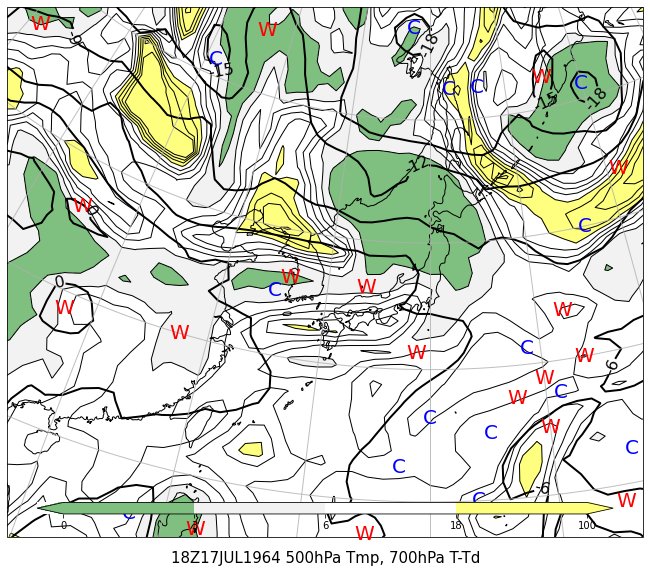

In [38]:
## 図のSIZE指定inch                                                              
fig = plt.figure(figsize=(10,8))                                          
## 余白設定                                                                      
plt.subplots_adjust(left=0, right=1, bottom=0.06, top=0.98)
## 図法指定
proj = ccrs.Stereographic(central_latitude=60, central_longitude=140)
latlon_proj = ccrs.PlateCarree() # 緯度経度の処理用に正距円筒図法も使う          
# 
## 図に関する設定                                                                
plt.rcParams["contour.negative_linestyle"] = 'solid'
## 余白  FAX図に合わせる                                                         
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(i_area, latlon_proj)
# 
## 海岸線など
ax.coastlines(resolution='50m',) # 海岸線の解像度を上げる
## グリッド線を引く                                                               
xticks=np.arange(0,360.1,dlon)
yticks=np.arange(-90,90.1,dlat)
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)
#
##
# ハッチ preTTd hPa面 T - Td                                                                        
cnf_ttd = ax.contourf(dsp['lon'], dsp['lat'], dsp['ttd'][1], levels_h_ttd, colors=levels_h_ttd_col,
                      alpha=0.5, extend='both', transform=latlon_proj )
cn_ttd = ax.contour(dsp['lon'], dsp['lat'], dsp['ttd'][1],
                    colors='black', linewidths=1.0,
                    levels=levels_ttd, transform=latlon_proj )
# 等値線 preTTd hPa面 T - Td  
# colorbarの位置と大きさ指定
#  add_axes([左端の距離, 下端からの距離, 横幅, 縦幅])                                      
ax_ttd = fig.add_axes([0.1, 0.1, 0.8, 0.02])
cb_ttd = fig.colorbar(cnf_ttd, orientation='horizontal', shrink=0.74,
                      aspect=40, pad=0.01, cax=ax_ttd)
##
# preT hPa面 等温度線
T0=273.15
cn_tmp = ax.contour(dsp['lon'], dsp['lat'],dsp['temperature'][0] - T0 * units('K'),
                    colors='black', linewidths=2.0,
                    levels=levels_tmp, transform=latlon_proj )
ax.clabel(cn_tmp, cn_tmp.levels, fontsize=16,
          inline=True, inline_spacing=1, colors='black',
          fmt='%i', rightside_up=True)
# -30,-36度は、青と紫の実線とする
cn_m30 = ax.contour(dsp['lon'], dsp['lat'], dsp['temperature'][0] - T0 * units('K'),
                    colors='blue', linewidths=2.0,
                    levels=[-30], transform=latlon_proj )
cn_m36 = ax.contour(dsp['lon'], dsp['lat'],dsp['temperature'][0] - T0 * units('K'),
                    colors='purple', linewidths=2.0,
                    levels=[-36], transform=latlon_proj )
# 
## W スタンプ
maxid = detect_peaks(dsp['temperature'][0].values, filter_size=4, dist_cut=2.0)
for i in range(len(maxid[0])):
  wlon = lon0[maxid[1][i]]
  wlat = lat0[maxid[0][i]]
  # 図の範囲内に座標があるか確認                                                                                                                        
  fig_z, _, _ = transform_lonlat_to_figure((wlon,wlat),ax,proj)
  if ( fig_z[0] > 0.0 and fig_z[0] < 1.0  and fig_z[1] > 0.0 and fig_z[1] < 1.0):
    ax.text(wlon, wlat, 'W', size=20, color="red",
            ha='center', va='center', transform=latlon_proj)
# 
## C スタンプ
minid = detect_peaks(dsp['temperature'][0].values, filter_size=4, dist_cut=2.0, flag=1)
for i in range(len(minid[0])):
  wlon = lon0[minid[1][i]]
  wlat = lat0[minid[0][i]]
  # 図の範囲内に座標があるか確認                                                                                                                        
  fig_z, _, _ = transform_lonlat_to_figure((wlon,wlat),ax,proj)
  if ( fig_z[0] > 0.0 and fig_z[0] < 1.0  and fig_z[1] > 0.0 and fig_z[1] < 1.0):
    ax.text(wlon, wlat, 'C', size=20, color="blue",
            ha='center', va='center', transform=latlon_proj)
#
# 図の説明
fig.text(0.5,0.01,dt_str+" {0}hPa Tmp, {1}hPa T-Td".format(int(preT),int(preTTd)),
         ha='center',va='bottom', size=15)
#
plt.show() 

In [39]:
## 出力                                                                                    
out_fn="jra55_{0}UTC_57.png".format(dt_str2)
plt.savefig(out_fn)
print("output:{}".format(out_fn))

output:jra55_1964071718UTC_57.png


<Figure size 432x288 with 0 Axes>